<p align="center">
    <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780081002858000055-f05-13-9780081002858.jpg" width="220" height="240" />

</p>

# Exploratory Data Analysis - Rod Pump Optimization

## Inventors Program Energy - NSC 325

#### Written by: Nicholas Khami, Nashra Ali, Vrishank Jannu

This notebook presents an implementation of a Random Forest Regression to predict the timing of a sucker rod pump failure. The data used for building the following model is provided by ConocoPhillips. The aim of this product is to assist production engineers in hypothesizing a better design for the downhole set-up in order to extend pump lifetimes. Thus, the company can cut yearly maintainence costs (i.e. part replacement) and consequently see an increase oil production per well. This benefits the company in guranteeing a higher return on their investments. 


### Imports

In [49]:
import glob
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import curve_fit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Minimal Data Cleaning
To begin approaching the problem, it is important to get a feel for the data that we will be working with. The following code displays the head of the data and dataframe properties. The data documents mechanical and chemical parameters of various sucker rod pumps owned by ConocoPhillips.

In [50]:
rpdf = pd.read_csv("../UT_RodPump_Dataset/rodpump_failure.csv")
rpdf.head()

,roduid,UWI,NODEID,IDWELL,tbguid,lifetime_start,lifetime_end,IDRECJOBPULL,REPORTTO,FAILSTART,FAILURETYPE,H2S_CONCENTRATION,PrimarySetpoint,SecondarySetpoint,StrokeLength,GrossStrokeLength,Fillage,YesterdaysAverageSPM,bha_configuration,chemgroup1_any,chemgroup1_all,chemgroup2_any,chemgroup2_all,chemgroup3_any,chemgroup3_all,max_unguided_dls,dls_high_in_hole,gas_anchor_length,MAX_INCLINATION,wellbore_category,manual_scale,packer_vs_tac,AVG_PRESS_FLOWLINE,AVG_PRESSURE_TUBING,AVG_PRESSURE_CASING,AVG_DIFFERENTIAL_PRESSURE,AVG_OIL_VOLUME,AVG_WATER_VOLUME,AVG_LIQUID_VOLUME,AVG_WATERSG,rod_sinker_type,rod_has_guides,rod_make,rod_apigrade,ROUTE,overall_max_sideload,shallow_max_sideload,max_unguided_sideload,DESANDDEGAS_TYP,CHROME_LENGTH,ENDURALLOY_LENGTH,POLY_LENGTH,NIPPLE_SET_DEPTH,pump_bore,gasanchor_od
0,GB27GKBE51029074693667,175-58-0111,box-child-doctor,GPVO63973435661154,GB55QFGB46756147811400,2014-05-02 00:00:00.000,2019-01-04 10:00:00.000,FGNB86581338411987,Tubing,2018-12-11 00:00:00.000,Tubing,0,75,60,144,108,91,6,TAC_ABOVE_NIP,1,1,1,1,0,0,2,1,19,2,Vertical,N,OTHER_ANCHOR,60,74,53,-21,51,59,109,1,SINKER_BARS_W_GUIDED_SUBS,False,strategize next-generation users,D,900,NaN,NaN,NaN,UNKNOWN,0,0,0,10025,1.5,NaN
1,GB53OEVX46438297645035,333-68-3523,outside-worry,ZAYT33358197650329,GB29QCCC14341267287129,2018-01-28 14:00:00.000,2019-05-17 12:00:00.000,XRYU81281518151403,Tubing,2019-04-01 00:00:00.000,Tubing,0,80,62,168,173,2,0,TAC_BELOW_NIP,1,1,0,0,0,0,2,2,17,2,Vertical,N,OTHER_ANCHOR,54,77,88,12,91,17,109,NaN,SINKER_BARS_W_GUIDED_SUBS,False,mesh enterprise portals,SpecialService,882,179,179,179,Miller LLC,0,0,0,10236,1.5,3.5
2,GB95BPWW35640301552066,165-51-5897,near-learn-simply,FNVL11432909873086,GB02DJAW44801752494129,2011-09-14 00:00:00.000,2012-08-20 00:00:00.000,PLPR44121073149707,Sucker Rod Pump,2012-08-01 00:00:00.000,Sucker Rod Pump,0,75,60,144,NaN,NaN,NaN,PACKER_DONNAN,0,0,0,0,0,0,5,5,21,2,Vertical,N,arrowset,NaN,74,56,-18,46,10,57,NaN,SLICK_SINKER_BARS,False,mesh enterprise portals,D,880,106,106,106,Miller LLC,0,0,0,10402,1.5,NaN
3,GB79UEDN31454825972680,543-56-3494,sea-improve-place,JOKL33317998159514,GB84GHPH97287631470412,2016-01-12 09:00:00.000,2017-03-16 16:30:00.000,MYCF04792093856141,Sucker Rod Pump,2017-01-19 00:00:00.000,Sucker Rod Pump,0,75,60,144,NaN,86,6,TAC_ABOVE_NIP,1,0,1,0,0,0,2,0,17,1,Vertical,Y,OTHER_ANCHOR,NaN,72,102,30,85,28,113,1,SINKER_BARS_W_GUIDED_SUBS,False,strategize next-generation users,D,875,98,48,98,Miller LLC,0,0,0,9558,1.75,4.5
4,GB20XCTM13691331349509,391-37-2039,personal-candidate,XOSU92041716672870,GB08VYTX61977431827206,2018-06-14 13:00:00.000,2020-04-15 17:37:11.338,WJDB83445325478746,NaN,NaN,NaN,0,80,65,168,127,61,4,TAC_BELOW_NIP,1,0,0,0,0,0,2,4,17,4,LowTangent,N,OTHER_ANCHOR,61,76,123,34,77,16,93,1,SUCKER_RODS_W_GUIDES,True,mesh enterprise portals,SpecialService,875,267,267,171,Miller LLC,0,129,0,9682,1.75,NaN


To begin cleaning, we convert unique well IDs to reformatted integer values and change lifetime_start, lifetime_end, and FAILSTART variables from date objects into integers. We create a new variable "lifetime" to represent the total time a particular pump operates (can be from the last failure time). This will serve as our response variable in the regression analysis. We will also at this stage drop rows with too many null values to be useful in training and testing and will replace any remaining null values with the integer value of 0.

In [51]:
rpdf = rpdf.dropna(subset=['FAILSTART'], axis=0)
rpdf['UWI'] = rpdf['UWI'].replace('-', '', regex=True).astype(int)

rpdf['lifetime_start'] = pd.to_datetime(rpdf['lifetime_start'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_start'] = rpdf['lifetime_start'].astype(np.int64)

rpdf['lifetime_end'] = pd.to_datetime(rpdf['lifetime_end'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_end'] = rpdf['lifetime_end'].astype(np.int64)

rpdf['FAILSTART'] = pd.to_datetime(rpdf['FAILSTART'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['FAILSTART'] = rpdf['FAILSTART'].astype(np.int64)

rpdf['pump_bore'].replace(to_replace="Other", value=0, inplace=True)
rpdf['pump_bore'] = rpdf['pump_bore'].astype(float)

rpdf['lifetime'] = rpdf['lifetime_end'] - rpdf['lifetime_start']

After doing some exploratory data analysis and reviewing summary statsitcs for each feauture, we found the following to be useful for our model: AVG_LIQUID_VOLUME (oil and water), overall_max_sideload, NIPPLE_SET_DEPTH, and all of the average pressures. There were several features such as StrokeLength and Fillage that we thought may be good predictors of failure, but they lacked differentiation throughout the dataframe. 

We think that the features listed are promising because they have differentiation across their quartiles and strong representation throughout the dataframe. Additionally, we hypothesize that they will reflect overall stress on the Rod Pump. 

In [52]:
rpdf.drop(['GrossStrokeLength', 'YesterdaysAverageSPM', 'shallow_max_sideload', 'max_unguided_sideload', 'CHROME_LENGTH', 'ENDURALLOY_LENGTH', 'POLY_LENGTH', 'gasanchor_od', 'chemgroup3_all', 'REPORTTO','H2S_CONCENTRATION','AVG_OIL_VOLUME','dls_high_in_hole', 'roduid', 'UWI', 'NODEID', 'IDWELL', 'tbguid', 'IDRECJOBPULL', 'PrimarySetpoint', 'chemgroup3_any', 'AVG_WATERSG'], axis=1, inplace=True)
rpdf.drop(['AVG_WATER_VOLUME'], axis=1, inplace=True)

Next, we assign an integer to each unique value for non-numeric columns of data (i.e. represented as integers or floats), known as label encoding. Any remaining null or incomprehensible (inf) values are replaced with the integer "0."

In [53]:
rpdf

,lifetime_start,lifetime_end,FAILSTART,FAILURETYPE,SecondarySetpoint,StrokeLength,Fillage,bha_configuration,chemgroup1_any,chemgroup1_all,chemgroup2_any,chemgroup2_all,max_unguided_dls,gas_anchor_length,MAX_INCLINATION,wellbore_category,manual_scale,packer_vs_tac,AVG_PRESS_FLOWLINE,AVG_PRESSURE_TUBING,AVG_PRESSURE_CASING,AVG_DIFFERENTIAL_PRESSURE,AVG_LIQUID_VOLUME,rod_sinker_type,rod_has_guides,rod_make,rod_apigrade,ROUTE,overall_max_sideload,DESANDDEGAS_TYP,NIPPLE_SET_DEPTH,pump_bore,lifetime
0,1398988800000000000,1546596000000000000,1544486400000000000,Tubing,60,144,91,TAC_ABOVE_NIP,1,1,1,1,2,19,2,Vertical,N,OTHER_ANCHOR,60,74,53,-21,109,SINKER_BARS_W_GUIDED_SUBS,False,strategize next-generation users,D,900,NaN,UNKNOWN,10025,2,147607200000000000
1,1517148000000000000,1558094400000000000,1554076800000000000,Tubing,62,168,2,TAC_BELOW_NIP,1,1,0,0,2,17,2,Vertical,N,OTHER_ANCHOR,54,77,88,12,109,SINKER_BARS_W_GUIDED_SUBS,False,mesh enterprise portals,SpecialService,882,179,Miller LLC,10236,2,40946400000000000
2,1315958400000000000,1345420800000000000,1343779200000000000,Sucker Rod Pump,60,144,NaN,PACKER_DONNAN,0,0,0,0,5,21,2,Vertical,N,arrowset,NaN,74,56,-18,57,SLICK_SINKER_BARS,False,mesh enterprise portals,D,880,106,Miller LLC,10402,2,29462400000000000
3,1452589200000000000,1489681800000000000,1484784000000000000,Sucker Rod Pump,60,144,86,TAC_ABOVE_NIP,1,0,1,0,2,17,1,Vertical,Y,OTHER_ANCHOR,NaN,72,102,30,113,SINKER_BARS_W_GUIDED_SUBS,False,strategize next-generation users,D,875,98,Miller LLC,9558,2,37092600000000000
6,1439942400000000000,1458691200000000000,1456444800000000000,Tubing,60,168,78,TAC_ABOVE_NIP,0,0,1,0,2,17,1,Vertical,Y,OTHER_ANCHOR,NaN,97,131,34,161,SLICK_SINKER_BARS,False,mesh enterprise portals,SpecialService,883,85,UNKNOWN,10158,2,18748800000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,1423440000000000000,1453420800000000000,1450828800000000000,Tubing,60,144,64,PACKER_DONNAN,0,0,1,0,1,21,2,Vertical,N,arrowset,NaN,70,116,46,127,SLICK_SINKER_BARS,False,strategize next-generation users,SpecialService,875,51,Miller LLC,10153,2,29980800000000000
2588,1434326400000000000,1507714200000000000,1462665600000000000,Rods,65,144,77,TAC_ABOVE_NIP,1,0,1,0,1,17,2,Vertical,N,OTHER_ANCHOR,NaN,56,131,75,35,SLICK_SINKER_BARS,False,strategize next-generation users,D,885,54,Miller LLC,9899,2,73387800000000000
2593,1542794400000000000,1546502400000000000,1543795200000000000,Rods,60,168,97,TAC_ABOVE_NIP,0,0,0,0,2,20,6,LowTangent,N,OTHER_ANCHOR,35,66,67,-5,43,SLICK_SINKER_BARS,True,strategize next-generation users,SpecialService,900,165,West-Washington,9014,2,3708000000000000
2594,1368748800000000000,1371513600000000000,1370044800000000000,Sucker Rod Pump,60,144,NaN,TAC_ABOVE_NIP,0,0,0,0,1,19,2,Vertical,N,OTHER_ANCHOR,NaN,59,78,19,42,SLICK_SINKER_BARS,False,strategize next-generation users,D,875,NaN,UNKNOWN,9532,2,2764800000000000


In [59]:
labelencoder = LabelEncoder()
rpdf_cleaned = rpdf.copy()

# rpdf_cleaned['roduid'] = labelencoder.fit_transform(rpdf_cleaned['roduid'])
# rpdf_cleaned['IDWELL'] = labelencoder.fit_transform(rpdf_cleaned['IDWELL'])
# rpdf_cleaned['tbguid'] = labelencoder.fit_transform(rpdf_cleaned['tbguid'])
# rpdf_cleaned['IDRECJOBPULL'] = labelencoder.fit_transform(rpdf_cleaned['IDRECJOBPULL'])
rpdf_cleaned['FAILURETYPE'] = labelencoder.fit_transform(rpdf_cleaned['FAILURETYPE'])
rpdf_cleaned['bha_configuration'] = labelencoder.fit_transform(rpdf_cleaned['bha_configuration'])
rpdf_cleaned['wellbore_category'] = labelencoder.fit_transform(rpdf_cleaned['wellbore_category'])
rpdf_cleaned['manual_scale'] = labelencoder.fit_transform(rpdf_cleaned['manual_scale'])
rpdf_cleaned['packer_vs_tac'] = labelencoder.fit_transform(rpdf_cleaned['packer_vs_tac'])
rpdf_cleaned['rod_has_guides'] = labelencoder.fit_transform(rpdf_cleaned['rod_has_guides'])
rpdf_cleaned['rod_make'] = labelencoder.fit_transform(rpdf_cleaned['rod_make'])
rpdf_cleaned['rod_apigrade'] = labelencoder.fit_transform(rpdf_cleaned['rod_apigrade'])
rpdf_cleaned['DESANDDEGAS_TYP'] = labelencoder.fit_transform(rpdf_cleaned['DESANDDEGAS_TYP'])
rpdf_cleaned['rod_sinker_type'] = labelencoder.fit_transform(rpdf_cleaned['rod_sinker_type'])
# rpdf_cleaned['NODEID'] = labelencoder.fit_transform(rpdf_cleaned['NODEID'])
rpdf_cleaned.fillna(0, inplace=True)
rpdf_cleaned.replace([np.inf, -np.inf], 0, inplace=True)
#rpdf_cleaned.fillna(method='ffill', inplace=True)

In [60]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', 55)
rpdf_numeric_summary = rpdf_cleaned.describe()
print(rpdf_numeric_summary.shape)
rpdf_numeric_summary

(8, 33)


,lifetime_start,lifetime_end,FAILSTART,FAILURETYPE,SecondarySetpoint,StrokeLength,Fillage,bha_configuration,chemgroup1_any,chemgroup1_all,chemgroup2_any,chemgroup2_all,max_unguided_dls,gas_anchor_length,MAX_INCLINATION,wellbore_category,manual_scale,packer_vs_tac,AVG_PRESS_FLOWLINE,AVG_PRESSURE_TUBING,AVG_PRESSURE_CASING,AVG_DIFFERENTIAL_PRESSURE,AVG_LIQUID_VOLUME,rod_sinker_type,rod_has_guides,rod_make,rod_apigrade,ROUTE,overall_max_sideload,DESANDDEGAS_TYP,NIPPLE_SET_DEPTH,pump_bore,lifetime
count,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725,1725
mean,1425118538260867328,1464088169016084480,1458605914539130624,1,58,148,59,3,0,0,0,0,3,18,4,2,0,1,31,81,115,34,127,1,0,3,3,883,135,2,9797,2,38969630755215056
std,102453440551570176,100767322746880992,99716157756249424,1,13,15,43,1,0,0,0,0,6,7,5,1,0,1,31,58,93,134,94,1,0,1,1,12,143,1,1031,0,35037583759650672
min,1093392000000000000,1133136000000000000,1133136000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-987,0,0,0,0,0,867,0,0,0,0,687600000000000
25%,1380240000000000000,1428537600000000000,1421625600000000000,1,60,144,0,1,0,0,0,0,1,17,2,1,0,0,0,61,66,0,69,1,0,2,1,873,0,1,9634,2,18230400000000000
50%,1450224000000000000,1491645960000000000,1483447800000000000,2,60,144,81,3,0,0,0,0,2,19,2,3,0,0,34,76,97,17,113,1,0,2,4,882,113,1,9938,2,29636940000000000
75%,1499509800000000000,1536408000000000000,1532217600000000000,2,60,144,93,3,1,0,1,0,3,21,6,3,0,1,60,97,144,57,164,1,1,3,4,886,210,4,10221,2,48423600000000000
max,1583431200000000000,1586972231337999872,1585872000000000000,3,100,216,655,5,1,1,1,1,92,45,53,4,1,5,248,1020,1108,4424,1583,3,1,5,5,905,1351,5,12026,2,335692800000000000


### Building the Model
We begin constructing our model by assigning a training and test set from the data. It is important that the training and test sets do not have any common data rows as this could affect the accuracy of our predictions. 70 percent of the cleaned data will be used for training while the remaining 30 percent will be used for testing.

In [61]:
X = rpdf_cleaned.drop(['FAILSTART', 'lifetime_start', 'lifetime_end', 'lifetime'], axis=1)
y = rpdf_cleaned['lifetime']

#split the data again into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

We now perform a grid search cross validation and randomized search cross validation to determine the best hyperparameters for the model. Based on score data, we will be using the hyperparameters determined by grid search CV for our random forest regression.

In [63]:
param_grid = {  'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}
rfr = RandomForestRegressor(random_state = 35)
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)
g_search.fit(X_train, y_train)
print(g_search.best_params_)

{'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'n_estimators': 15}


In [64]:
g_search.best_score_

0.46375910553871186

In [44]:
rfr_random_reg = RandomForestRegressor(random_state = 35)
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt', 'log2'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points
r_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
print(r_grid)

{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]}


In [65]:
rfr_random = RandomizedSearchCV(estimator=rfr_random_reg, param_distributions=r_grid, n_iter = 20, scoring='neg_mean_absolute_error', cv = 3, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)
rfr_random.fit(X_train, y_train)
print(rfr_random.best_score_)
print(rfr_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
-1.809541599336934e+16
{'n_estimators': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': False}


In [66]:
print(rfr_random.score(X_test , y_test))

-1.7189140419252138e+16


We now create a random forest regressor object and pass our training set to it. The following code displays the weights of each predictor variable in relation to their correlation with sucker rod pump lifespan.

Feature: FAILURETYPE, Score: 0.01091
Feature: SecondarySetpoint, Score: 0.05047
Feature: StrokeLength, Score: 0.04829
Feature: Fillage, Score: 0.03310
Feature: bha_configuration, Score: 0.03412
Feature: chemgroup1_any, Score: 0.01084
Feature: chemgroup1_all, Score: 0.04354
Feature: chemgroup2_any, Score: 0.03566
Feature: chemgroup2_all, Score: 0.08035
Feature: max_unguided_dls, Score: 0.05117
Feature: gas_anchor_length, Score: 0.04166
Feature: MAX_INCLINATION, Score: 0.03622
Feature: wellbore_category, Score: 0.00643
Feature: manual_scale, Score: 0.00547
Feature: packer_vs_tac, Score: 0.01332
Feature: AVG_PRESS_FLOWLINE, Score: 0.03698
Feature: AVG_PRESSURE_TUBING, Score: 0.06182
Feature: AVG_PRESSURE_CASING, Score: 0.04930
Feature: AVG_DIFFERENTIAL_PRESSURE, Score: 0.03964
Feature: AVG_LIQUID_VOLUME, Score: 0.11298
Feature: rod_sinker_type, Score: 0.00662
Feature: rod_has_guides, Score: 0.00411
Feature: rod_make, Score: 0.00677
Feature: rod_apigrade, Score: 0.01473
Feature: ROUTE, Sco

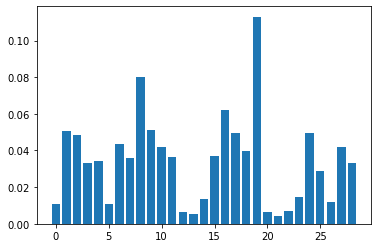

In [67]:
reg = RandomForestRegressor(bootstrap = True, max_depth = None, max_features = 'log2', n_estimators = 13)
reg.fit(X_train, y_train)
feature_names = list(X_train.columns)

importance = reg.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    if v < 1.0:
        print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

The R^2 value gives us an idea of how accurate our model is in prediciting sucker rod pump lifetimes.

In [68]:
#score it up
reg.score(X_test, y_test)

0.3549974325049695

We can finally visualize the results of our model through the following graphic.

In [69]:
# #and export so we can visualize what is going on
for k in range(12):
   dot_data = tree.export_graphviz(reg.estimators_[k+1], out_file='reggraph_' + str((k+1)), feature_names=X.columns, filled=True)
# tree.plot_tree(reg.estimators_[1])